In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import pandas as pd
import cst
import pyaldata

import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)


# Speficy whether or not to save figures
save_figures = False

In [2]:
filename = '/home/raeed/data/project-data/smile/cst-gainlag/library/python/Ford_20180618_COCST_TD.mat'
# td = cst.get_cst_dataframe(filename)
td = pyaldata.mat2dataframe(filename,True,'td_cst')
td.set_index('trial_id',inplace=True)

In [3]:
cursor_pos = td.loc[151,'cursor_pos']
cursor_vel = td.loc[151,'cursor_vel']

np.column_stack((cursor_pos[:,1],cursor_vel[:,1]))

array([[469.17173627,  11.00291774],
       [469.21195343,  36.83392798],
       [469.24540413,  29.13944929],
       ...,
       [576.18223602,   8.08692442],
       [576.19026113,   7.81268671],
       [576.19786139,   7.25338698]])

  0%|          | 0/50 [00:00<?, ?it/s]

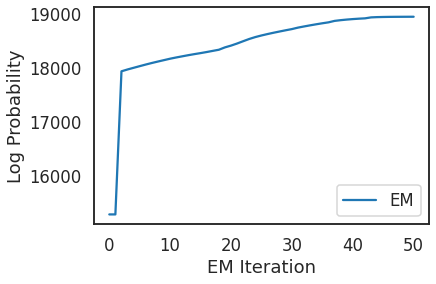

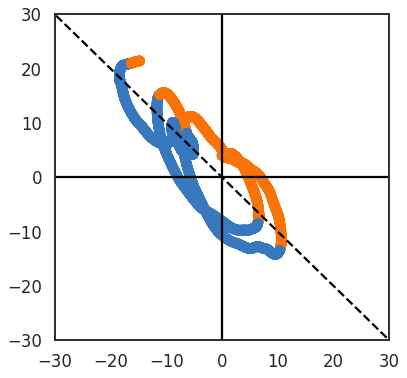

In [6]:
num_states = 2
obs_dim = 1
input_dims = 2
N_iters = 50
trial_id_list = [180]

hmm = ssm.HMM(num_states, obs_dim, M=input_dims, observations="autoregressive",transitions='recurrent_only')

for trial_id in trial_id_list:
    cursor_pos = td.loc[trial_id,'cursor_pos']
    cursor_vel = td.loc[trial_id,'cursor_vel']
    hand_pos = td.loc[trial_id,'hand_pos']
    hand_vel = td.loc[trial_id,'hand_vel']
    time_bins = cursor_pos.shape[0]
    
    vis_input = np.column_stack((cursor_pos[:,0],cursor_vel[:,0]))
    # control_obs = np.column_stack((hand_pos[:,0],hand_vel[:,0]))
    control_obs = hand_pos[:,0][:,None]

    hmm_lls = hmm.fit(control_obs, inputs=vis_input, method="em", num_iters=N_iters, init_method="kmeans") #can also use random for initialization method, which sometimes works better

    # Plot the true and inferred discrete states
    hmm_z = hmm.most_likely_states(control_obs,input=vis_input)
    
    # make plots
    plt.plot(hmm_lls, label="EM")
    plt.xlabel("EM Iteration")
    plt.ylabel("Log Probability")
    plt.legend(loc="lower right")
    plt.show()
    
    scale = 30
    plt.figure(figsize=(6,6))
    plt.plot([-60,60],[60,-60],'--k')
    plt.plot([0,0],[-60,60],'-k')
    plt.plot([-60,60],[0,0],'-k')
    plt.scatter(cursor_pos[:,0],hand_pos[:,0],c=hmm_z,cmap=cmap)
    plt.xlim(-scale,scale)
    plt.ylim(-scale,scale)
    
    

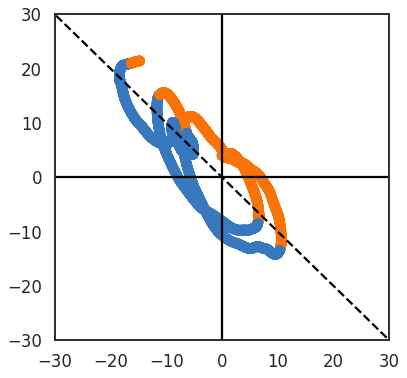

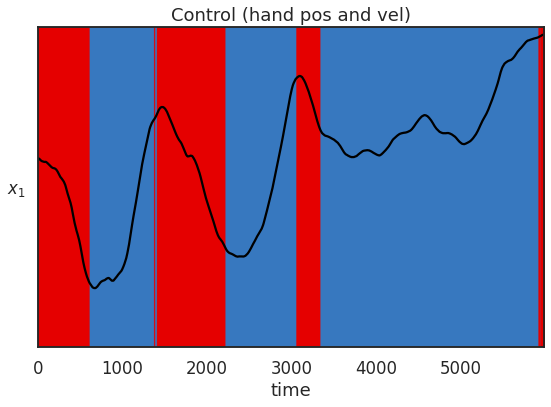

In [7]:
scale = 30
plt.figure(figsize=(6,6))
plt.plot([-60,60],[60,-60],'--k')
plt.plot([0,0],[-60,60],'-k')
plt.plot([-60,60],[0,0],'-k')
plt.scatter(cursor_pos[:,0],hand_pos[:,0],c=hmm_z,cmap=cmap)
plt.xlim(-scale,scale)
plt.ylim(-scale,scale)

lim = 1.05 * abs(control_obs).max()
plt.figure(figsize=(8, 6))
plt.imshow(hmm_z[None,:],
           aspect="auto",
           cmap=cmap,
           vmin=0,
           vmax=len(colors)-1,
           extent=(0, time_bins, -lim, (obs_dim)*lim))

for d in range(obs_dim):
    plt.plot(control_obs[:,d] + lim * d, '-k')

plt.xlim(0, time_bins)
plt.xlabel("time")
plt.yticks(lim * np.arange(obs_dim), ["$x_{}$".format(d+1) for d in range(obs_dim)])

plt.title("Control (hand pos and vel)")

plt.tight_layout()

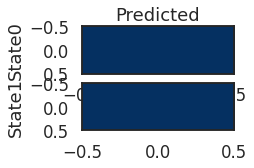

In [8]:
for i in range(num_states):
    plt.subplot(4,2,2*i+2)
    plt.imshow(hmm.observations.As[i],aspect='auto',cmap='RdBu',clim=[-1,1])
    if i==0:
        plt.title('Predicted')
    plt.ylabel('State'+str(i))


In [15]:
hmm.observations.Vs

array([[[ 5.28452964e-02, -1.51205342e-02]],

       [[-1.12862960e-03,  2.81575364e-08]]])